In [21]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
import os

if os.path.isdir("/content/drive/MyDrive/4_ING_INFORMATICA/tfg/tfg/experiments/taming_transformers/taming-transformers/"):
  %cd "/content/drive/MyDrive/4_ING_INFORMATICA/tfg/tfg/experiments/taming_transformers/taming-transformers/"
else:
  %cd "/content/drive/MyDrive/4_ING_INFORMATICA/tfg/tfg/experiments/taming_transformers/"
  !git clone https://github.com/CompVis/taming-transformers
  %cd "taming-transformers"

/content/drive/MyDrive/4_ING_INFORMATICA/tfg/tfg/experiments/taming_transformers/taming-transformers


In [23]:
%%capture
%pip install omegaconf>=2.0.0 pytorch-lightning>=1.0.8 einops>=0.3.0
import sys
sys.path.append(".")

# also disable grad to save memory
import torch
torch.set_grad_enabled(False)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [24]:
import yaml
import torch
from omegaconf import OmegaConf
from taming.models.vqgan import VQModel, GumbelVQ

def load_config(config_path, display=False):
  config = OmegaConf.load(config_path)
  if display:
    print(yaml.dump(OmegaConf.to_container(config)))
  return config

def load_vqgan(config, ckpt_path=None, is_gumbel=False):
  if is_gumbel:
    model = GumbelVQ(**config.model.params)
  else:
    model = VQModel(**config.model.params)
  if ckpt_path is not None:
    sd = torch.load(ckpt_path, map_location="cpu")["state_dict"]
    missing, unexpected = model.load_state_dict(sd, strict=False)
  return model.eval()

def preprocess_vqgan(x):
  x = 2.*x - 1.
  return x

def custom_to_pil(x):
  x = x.detach().cpu()
  x = torch.clamp(x, -1., 1.)
  x = (x + 1.)/2.
  x = x.permute(1,2,0).numpy()
  x = (255*x).astype(np.uint8)
  x = Image.fromarray(x)
  if not x.mode == "RGB":
    x = x.convert("RGB")
  return x

def reconstruct_with_vqgan(x, model):
  # could also use model(x) for reconstruction but use explicit encoding and decoding here
  z, _, [_, _, indices] = model.encode(x)
  print(f"VQGAN --- {model.__class__.__name__}: latent shape: {z.shape[2:]}")
  xrec = model.decode(z)
  return xrec

In [25]:
project_path = "/Users/pedrobedmar/GoogleDrive/4_ING_INFORMATICA/tfg/tfg/experiments/taming_transformers/taming-transformers/"

config_8ep = load_config("logs/2022-03-10T13-17-06_custom_vqgan/configs/2022-03-10T13-17-06-project.yaml", display=False)
model_8ep = load_vqgan(config_8ep, ckpt_path="logs/2022-03-10T13-17-06_custom_vqgan/checkpoints/last.ckpt").to(DEVICE)

config_16ep = load_config("logs/2022-03-13T12-11-25_custom_vqgan/configs/2022-03-13T12-11-25-project.yaml", display=False)
model_16ep = load_vqgan(config_16ep, ckpt_path="logs/2022-03-13T12-11-25_custom_vqgan/checkpoints/last.ckpt").to(DEVICE)

config_32ep = load_config("logs/2022-03-13T12-44-33_custom_vqgan/configs/2022-03-13T12-44-33-project.yaml", display=False)
model_32ep = load_vqgan(config_32ep, ckpt_path="logs/2022-03-13T12-44-33_custom_vqgan/checkpoints/last.ckpt").to(DEVICE)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


In [32]:
import io
import os, sys
import requests
import PIL
from PIL import Image
from PIL import ImageDraw, ImageFont
import numpy as np

import torch
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF

from IPython.display import display, display_markdown

font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSans-BoldItalic.ttf", 12)

def download_image(url):
    resp = requests.get(url)
    resp.raise_for_status()
    return PIL.Image.open(io.BytesIO(resp.content))


def preprocess(img, target_image_size=192, map_dalle=True):
    s = min(img.size)
    
    if s < target_image_size:
        raise ValueError(f'min dim for image {s} < {target_image_size}')
        
    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    print("Unsqueezed:", img.shape)
    return img

def stack_reconstructions(input, x0, x1, x2, titles=[]):
  assert input.size == x0.size == x1.size == x2.size 
  w, h = input.size[0], input.size[1]
  img = Image.new("RGB", (4*w, h))
  img.paste(input, (0,0))
  img.paste(x0, (1*w,0))
  img.paste(x1, (2*w,0))
  img.paste(x2, (3*w,0))
  for i, title in enumerate(titles):
    ImageDraw.Draw(img).text((i*w, 0), f'{title}', (0, 0, 0), font=font) # coordinates, text, color, font
  return img

In [39]:
titles=["Input", "Custom VQGAN - 192x192 - 8ep", "Custom VQGAN - 192x192 - 16ep", "Custom VQGAN - 192x192 - 32ep",]

def reconstruction_pipeline(file, size=192, origin_format=0):
  if origin_format is 0:
    x_vqgan = preprocess(download_image(file), target_image_size=size, map_dalle=False)
  elif origin_format is 1:
    file = PIL.Image.open(file)
    x_vqgan = preprocess(file, target_image_size=size, map_dalle=False)
  else:
    x_vqgan = file

  x_vqgan = x_vqgan.to(DEVICE)
  
  print(f"input is of size: {x_vqgan.shape}")
  x0 = reconstruct_with_vqgan(preprocess_vqgan(x_vqgan), model_8ep)
  x1 = reconstruct_with_vqgan(preprocess_vqgan(x_vqgan), model_16ep)
  x2 = reconstruct_with_vqgan(preprocess_vqgan(x_vqgan), model_32ep)
  img = stack_reconstructions(custom_to_pil(preprocess_vqgan(x_vqgan[0])), custom_to_pil(x0[0]), custom_to_pil(x1[0]), custom_to_pil(x2[0]), titles=titles)
  return img

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:405: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


Unsqueezed: torch.Size([1, 3, 192, 192])
input is of size: torch.Size([1, 3, 192, 192])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])


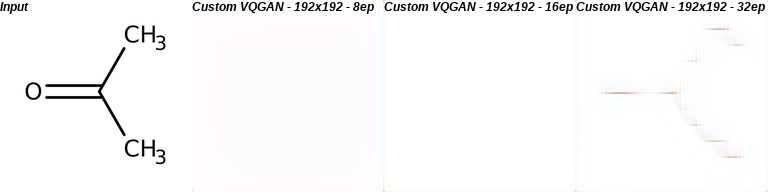

In [34]:
reconstruction_pipeline('https://assets.fishersci.com/TFS-Assets/CCG/Chemical-Structures/chemical-structure-cas-67-64-1.jpg-650.jpg')

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:405: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


input is of size: torch.Size([1, 3, 192, 192])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])


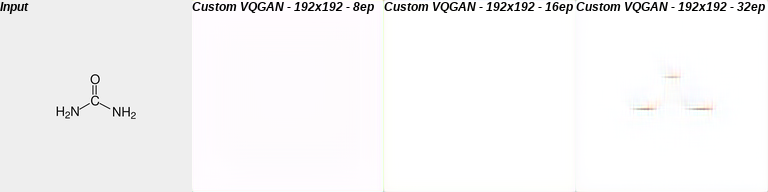

In [31]:
reconstruction_pipeline('https://i.pinimg.com/736x/3f/26/21/3f2621fa39b9ed4706ba1edba07d61c5.jpg')

input is of size: torch.Size([1, 3, 192, 192])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])


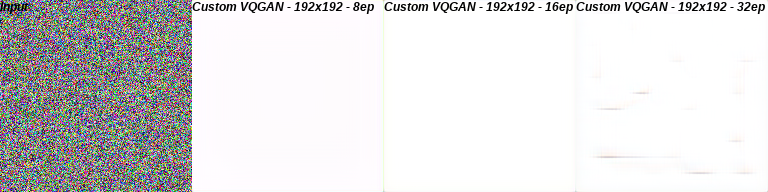

In [41]:
random_noise = torch.rand(1,3,192,192)
reconstruction_pipeline(random_noise, origin_format=2)

input is of size: torch.Size([1, 3, 192, 192])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])


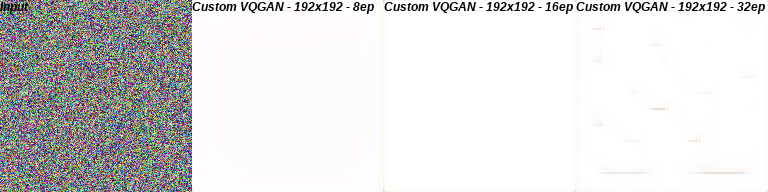

In [42]:
random_noise2 = torch.rand(1,3,192,192)
reconstruction_pipeline(random_noise2, origin_format=2)